# Getting started with astir

## Table of Contents:
* [0 Loading necessary libraries](#0.-Load-necessary-libraries)
* [1 Load data](#1.-Load-data)
* [2 Fitting cell type](#2.-Fitting-cell-types)
* [3 Fitting cell state](#3.-Fitting-cell-state)
* [4 Saving results](#4.-Saving-results)
* [5 Accessing internal functions and data](#5.-Accessing-internal-functions-and-data)
* [6 Saving models](#6.-Saving-models)
* [7 Plot clustermap of expression data](#7.-Plot-clustermap-of-expression-data)
* [8 Hierarchical model specification](#8.-Hierarchical-model-specification)
* [9 Using astir as command line tool](#9.-Using-astir-as-command-line-tool)

## 0. Load necessary libraries <a class="anchor" id="0.-Load-necessary-libraries"></a>

In [2]:
# !pip install -e ../../..
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from astir.data import from_csv_yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data <a class="anchor" id="1.-Load-data"></a>

We start by reading expression data in the form of a csv file and marker gene information in the form of a yaml file:

In [18]:
expression_mat_path = "../../../astir/tests/test-data/sce.csv"
# expression_mat_path = "data/sample_data.csv"
yaml_marker_path = "../../../astir/tests/test-data/jackson-2020-markers.yml"

.. note:: 
    Expression data should already be cleaned and normalized. In our workflow, we perform this by a log-transformation of the data with a pseudocount of 1 (i.e. `log(x+1)`), followed by winsorization at the (1%,99%) percentiles.

We can view both the expression data and marker data:

In [22]:
!head -n 20 ../../../astir/tests/test-data/jackson-2020-markers.yml

cell_states:
  RTK_signalling:
    - Her2
    - EGFR
  cell_growth:
    - Ki-67
    - phospho mTOR
  mTOR_signalling:
    - phospho mTOR
    - phospho S6
  apoptosis:
    - cleaved PARP
    - Cleaved Caspase3

cell_types:
  stromal:
    - Vimentin
    - Fibronectin
  B cells:
    - CD45


In [7]:
pd.read_csv(expression_mat_path, index_col=0)[['EGFR','E-Cadherin', 'CD45', 'Cytokeratin 5']].head()

,EGFR,E-Cadherin,CD45,Cytokeratin 5
BaselTMA_SP41_186_X5Y4_3679,0.346787,0.938354,0.227730,0.095283
BaselTMA_SP41_153_X7Y5_246,0.833752,1.364884,0.068526,0.124031
BaselTMA_SP41_20_X12Y5_197,0.110006,0.177361,0.301222,0.052750
BaselTMA_SP41_14_X1Y8_84,0.282666,1.122174,0.606941,0.093352
BaselTMA_SP41_166_X15Y4_266,0.209066,0.402554,0.588273,0.064545


Then we can create an astir object using the `from_csv_yaml` function. For more data loading options, see the data loading tutorial.

In [23]:
ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
print(ast)

Astir object with 6 cell types, 4 cell states, and 4931 cells.


## 2. Fitting cell types <a class="anchor" id="2.-Fitting-cell-types"></a>

To fit cell types, simply call

In [24]:
ast.fit_type(max_epochs=10, n_init=3, n_init_epochs=2)

training restart (final):  94%|█████████▍| 47/50 [ 3.51s/epochs, current loss: -17252.6]


.. note:: 
    **Controlling inference**
    There are many different options for controlling inference in the `fit_type` function, including
    `max_epochs` (maximum number of epochs to train),
    `learning_rate` (ADAM optimizer learning rate),
    `batch_size` (minibatch size),
    `delta_loss` (stops iteration once the change in loss falls below this value),
    `n_inits` (number of restarts using random initializations).
    For full details, see the function documentation.

We should always plot the losses to assess convergence:

Text(0.5, 0, 'Epoch')

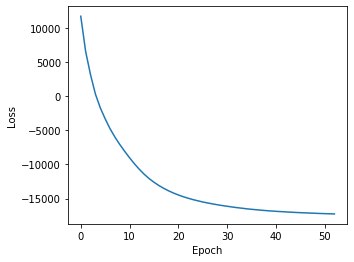

In [25]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

We can then get cell type assignment probabilities by calling

In [26]:
assignments = ast.get_celltype_probabilities()
assignments

,stromal,B cells,T cells,macrophage,epithelial(basal),epithelial(luminal),Other
BaselTMA_SP43_115_X4Y8_1,5.981264e-05,4.351427e-01,4.413378e-06,4.778704e-05,0.005910,0.000002,5.588340e-01
BaselTMA_SP43_115_X4Y8_2,7.080264e-05,3.849646e-01,5.889273e-06,4.314298e-05,0.044710,0.000007,5.701980e-01
BaselTMA_SP43_115_X4Y8_3,2.086748e-04,1.871444e-01,9.592506e-04,4.061270e-04,0.290781,0.039960,4.805403e-01
BaselTMA_SP43_115_X4Y8_4,2.980559e-04,4.438626e-01,6.048962e-06,1.707915e-04,0.011950,0.000006,5.437063e-01
BaselTMA_SP43_115_X4Y8_5,1.121071e-04,4.681895e-01,2.136392e-05,3.064268e-05,0.017083,0.000002,5.145617e-01
...,...,...,...,...,...,...,...
BaselTMA_SP43_115_X4Y8_4927,4.338320e-07,1.912927e-03,2.400906e-07,1.376804e-06,0.993716,0.000003,4.365914e-03
BaselTMA_SP43_115_X4Y8_4928,2.193680e-04,3.908094e-01,3.504072e-04,2.164537e-04,0.009062,0.000018,5.993251e-01
BaselTMA_SP43_115_X4Y8_4929,1.189970e-08,7.369497e-07,5.310283e-09,8.920690e-09,0.999534,0.000464,8.322494e-07
BaselTMA_SP43_115_X4Y8_4930,5.812946e-08,6.018526e-09,2.364501e-08,5.991192e-09,0.000590,0.999410,6.340690e-08


We can also visualize the assignment probabilities using a heatmap:

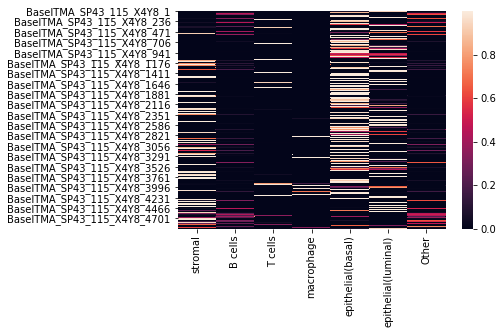

In [27]:
sns.heatmap(assignments)

where each row corresponds to a cell, and each column to a cell type, with the entry being the probability of that cell belonging to a particular cell type.

To fetch an array corresponding to the most likely cell type assignments, call

In [28]:
ast.get_celltypes()

,cell_type
BaselTMA_SP43_115_X4Y8_1,Unknown
BaselTMA_SP43_115_X4Y8_2,Unknown
BaselTMA_SP43_115_X4Y8_3,Unknown
BaselTMA_SP43_115_X4Y8_4,Unknown
BaselTMA_SP43_115_X4Y8_5,Unknown
...,...
BaselTMA_SP43_115_X4Y8_4927,epithelial(basal)
BaselTMA_SP43_115_X4Y8_4928,Unknown
BaselTMA_SP43_115_X4Y8_4929,epithelial(basal)
BaselTMA_SP43_115_X4Y8_4930,epithelial(luminal)


### Cell type diagnostics

It is important to run diagnostics to ensure that cell types express their markers at higher levels than other cell types. To do this, run the `diagnostics_celltype()` function, which will alert to any issues if a cell type doesn't express its marker signficantly higher than an alternative cell type (for which that protein isn't a marker):

In [29]:
ast.diagnostics_celltype().head(n=10)

,feature,should be expressed higher in,than,mean cell type 1,mean cell type 2,p-value,note
0,Fibronectin,stromal,B cells,2.045195,1.565420,inf,Only 1 cell in a type: comparison not possible
1,Vimentin,stromal,B cells,2.994335,1.095477,inf,Only 1 cell in a type: comparison not possible
2,CD20,B cells,stromal,0.403677,0.081944,inf,Only 1 cell in a type: comparison not possible
3,CD20,B cells,T cells,0.403677,0.123195,inf,Only 1 cell in a type: comparison not possible
4,CD20,B cells,macrophage,0.403677,0.212008,inf,Only 1 cell in a type: comparison not possible
5,CD20,B cells,epithelial(basal),0.403677,0.118228,inf,Only 1 cell in a type: comparison not possible
6,CD20,B cells,epithelial(luminal),0.403677,0.131991,inf,Only 1 cell in a type: comparison not possible
7,CD20,B cells,Other,0.403677,0.017356,inf,Only 1 cell in a type: comparison not possible
8,CD45,B cells,stromal,0.077596,0.227257,inf,Only 1 cell in a type: comparison not possible
9,CD45,B cells,epithelial(basal),0.077596,0.182078,inf,Only 1 cell in a type: comparison not possible


.. note:: 
    In this tutorial, we end up with many "Only 1 cell in a type: comparison not possible" notes - this is simply because the small dataset size results in only a single cell assigned to many types, making statistical testing infeasible.

Calling `ast.diagnostics_celltype()` returns a `pd.DataFrame`, where each column corresponds to a particular protein and two cell types, with a warning if the protein is not expressed at higher levels in the cell type for which it is a marker than the cell type for which it is not.

The diagnostics:

1. Iterates through every cell type and every marker for that cell type

2. Given a cell type *c* and marker *g*, find the set of cell types *D* that don't have *g* as a marker

3. For each cell type *d* in *D*, perform a t-test between the expression of marker *g* in *c* vs *d*

4. If *g* is not expressed significantly higher (at significance *alpha*), output a diagnostic explaining this for further investigation.

If multiple issues are found, the markers and cell types may need refined.

## 3. Fitting cell state <a class="anchor" id="3.-Fitting-cell-state"></a>

Similarly as before, to fit cell state, call

In [30]:
ast.fit_state(batch_size = 1024, learning_rate=1e-3, max_epochs=10)

/Users/jinelles.h/Documents/Camlab/astir-top-level/astir/astir/models/cellstate.py:176: UserWarning: Delta loss batch size is greater than the number of epochs
  warnings.warn("Delta loss batch size is greater than the number of epochs")
training restart (final): 100%|██████████| 50/50 [ 3.60s/epochs, current loss: 14.5]
/Users/jinelles.h/Documents/Camlab/astir-top-level/astir/astir/astir.py:268: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


and similary plot the losses via

Text(0.5, 0, 'Epoch')

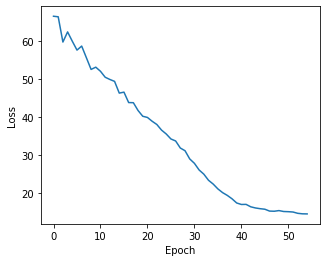

In [31]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_state_losses())), ast.get_state_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

and cell state assignments can be inferred via

In [32]:
states = ast.get_cellstates()
states

,RTK_signalling,cell_growth,mTOR_signalling,apoptosis
BaselTMA_SP43_115_X4Y8_1,0.219178,0.178849,0.133436,0.144105
BaselTMA_SP43_115_X4Y8_2,0.296468,0.119678,0.200147,0.157937
BaselTMA_SP43_115_X4Y8_3,0.181820,0.185739,0.117271,0.117391
BaselTMA_SP43_115_X4Y8_4,0.271369,0.091272,0.145709,0.170535
BaselTMA_SP43_115_X4Y8_5,0.238632,0.219416,0.147383,0.165110
...,...,...,...,...
BaselTMA_SP43_115_X4Y8_4927,0.377885,0.229766,0.257093,0.232393
BaselTMA_SP43_115_X4Y8_4928,0.144620,0.335371,0.105722,0.134628
BaselTMA_SP43_115_X4Y8_4929,0.494012,0.387052,0.286395,0.357899
BaselTMA_SP43_115_X4Y8_4930,0.624909,0.492357,0.315533,0.519452


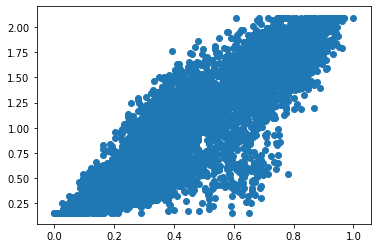

In [33]:
plt.scatter(
    states['RTK_signalling'],
    ast.get_state_dataset().get_exprs_df()['Her2']
)

### Cell state diagnostics

It is important to run diagnostics on cell states model for the same reasons
stated for the cell type model. `Astir.diagnostics_cellstate()` spots any non
 marker protein and pathway pairs whose expressions are higher than those of
 the marker proteins of the pathway.

In [34]:
ast.diagnostics_cellstate().head(n=10)

,pathway,protein A,correlation of protein A,protein B,correlation of protein B,note
0,RTK_signalling,EGFR,0.823298,Cleaved Caspase3,0.831128,EGFR is marker for RTK_signalling but Cleaved ...
1,RTK_signalling,EGFR,0.823298,cleaved PARP,0.831128,EGFR is marker for RTK_signalling but cleaved ...
2,cell_growth,Ki-67,0.058879,Cleaved Caspase3,0.862459,Ki-67 is marker for cell_growth but Cleaved Ca...
3,cell_growth,Ki-67,0.058879,EGFR,0.897650,Ki-67 is marker for cell_growth but EGFR isn't
4,cell_growth,Ki-67,0.058879,Her2,0.750985,Ki-67 is marker for cell_growth but Her2 isn't
5,cell_growth,Ki-67,0.058879,cleaved PARP,0.862459,Ki-67 is marker for cell_growth but cleaved PA...
6,cell_growth,Ki-67,0.058879,phospho S6,0.272989,Ki-67 is marker for cell_growth but phospho S6...
7,mTOR_signalling,phospho S6,0.699387,EGFR,0.720013,phospho S6 is marker for mTOR_signalling but E...
8,mTOR_signalling,phospho S6,0.699387,Her2,0.757867,phospho S6 is marker for mTOR_signalling but H...


Calling `ast.diagnostics_cellstate()` returns a `pd.DataFrame`, where each
column corresponds to a particular protein and two cell types, with a warning
 if the protein is not expressed at higher levels in the cell state for which
 it is a marker than the cell state for which it is not.

The diagnostics:

1. Get correlations between all cell states and proteins

2. For each cell state *c*, get the smallest correlation with marker *g*

3. For each cell state *c* and its non marker *g*, find any correlation that is
bigger than those smallest correlation for *c*.

4. Any *c* and *g* pairs found in step 3 will be included in the output of
`Astir.diagnostics_cellstate()`, including an explanation.

If multiple issues are found, the markers and cell states may need refined.


## 4. Saving results <a class="anchor" id="4.-Saving-results"></a>

Both cell type and cell state information can easily be saved to disk via

In [35]:
ast.type_to_csv("data/cell-types.csv")
ast.state_to_csv("data/cell-states.csv")

In [37]:
!head -n 3 data/cell-types.csv

,stromal,B cells,T cells,macrophage,epithelial(basal),epithelial(luminal),Other
BaselTMA_SP43_115_X4Y8_1,5.9812641356773485e-05,0.43514272442399615,4.4133780759206555e-06,4.778704083811438e-05,0.00590960852651017,1.6351770806453748e-06,0.5588340188121422
BaselTMA_SP43_115_X4Y8_2,7.080264289768121e-05,0.38496458175145926,5.889272783675721e-06,4.3142984449199766e-05,0.04471036731616506,7.2442437475747445e-06,0.5701979717884975


In [38]:
!head -n 3 data/cell-states.csv

,RTK_signalling,cell_growth,mTOR_signalling,apoptosis
BaselTMA_SP43_115_X4Y8_1,0.2191776340692214,0.17884886731101723,0.13343558969907734,0.1441052515306596
BaselTMA_SP43_115_X4Y8_2,0.29646752007327026,0.11967817733248733,0.20014708539822942,0.1579368118796618


where the first (unnamed) column always corresponds to the cell name/ID.

## 5. Accessing internal functions and data <a class="anchor" id="5.-Accessing-internal-functions-and-data"></a>

Data stored in `astir` objects is in the form of an `SCDataSet`. These can be retrieved via

In [39]:
celltype_data = ast.get_type_dataset()
celltype_data

and similarly for cell state via `ast.get_state_dataset()`.

These have several helper functions to retrieve relevant information to the dataset:

In [40]:
celltype_data.get_cell_names()[0:4] # cell names

['BaselTMA_SP43_115_X4Y8_1',
 'BaselTMA_SP43_115_X4Y8_2',
 'BaselTMA_SP43_115_X4Y8_3',
 'BaselTMA_SP43_115_X4Y8_4']

In [41]:
celltype_data.get_classes() # cell type names

['stromal',
 'B cells',
 'T cells',
 'macrophage',
 'epithelial(basal)',
 'epithelial(luminal)']

In [42]:
print(celltype_data.get_n_classes()) # number of cell types
print(celltype_data.get_n_features()) # number of features / proteins

6
14


In [43]:
celltype_data.get_exprs() # Return a torch tensor corresponding to the expression data used

tensor([[4.2121e-02, 5.2044e-02, 1.7348e-03,  ..., 6.1314e-01, 4.4827e-02,
         3.8841e-01],
        [0.0000e+00, 3.4770e-02, 0.0000e+00,  ..., 9.4025e-01, 1.9424e-02,
         5.6716e-01],
        [1.8200e-02, 7.8596e-02, 0.0000e+00,  ..., 6.2852e-01, 4.0905e-02,
         8.4946e-01],
        ...,
        [1.4403e-01, 7.0877e-02, 2.0325e-01,  ..., 1.7303e+00, 2.1434e-01,
         9.4889e-01],
        [3.6400e-02, 9.9307e-02, 1.1815e-01,  ..., 1.6467e+00, 1.3463e-01,
         1.9238e+00],
        [5.4069e-02, 1.1861e-01, 5.3894e-02,  ..., 1.4265e+00, 4.9443e-01,
         1.6126e+00]], dtype=torch.float64)

In [44]:
celltype_data.get_exprs_df() # Return a pandas DataFrame corresponding to the expression data used

,CD20,CD3,CD45,CD68,Cytokeratin 14,Cytokeratin 19,Cytokeratin 5,Cytokeratin 7,Cytokeratin 8/18,E-Cadherin,Fibronectin,Her2,Vimentin,pan Cytokeratin
BaselTMA_SP43_115_X4Y8_1,0.042121,0.052044,0.001735,0.042628,0.046076,0.076746,0.113790,0.073571,0.110530,0.800019,0.324533,0.613138,0.044827,0.388409
BaselTMA_SP43_115_X4Y8_2,0.000000,0.034770,0.000000,0.084581,0.059064,0.056487,0.098873,0.019242,0.152825,0.972369,0.384034,0.940250,0.019424,0.567159
BaselTMA_SP43_115_X4Y8_3,0.018200,0.078596,0.000000,0.042628,0.026254,0.126815,0.165966,0.310404,0.253835,1.108996,0.256832,0.628524,0.040905,0.849462
BaselTMA_SP43_115_X4Y8_4,0.000000,0.018701,0.015682,0.108294,0.071382,0.052757,0.022484,0.093607,0.062275,1.204820,0.661950,0.530076,0.093848,0.418222
BaselTMA_SP43_115_X4Y8_5,0.099789,0.073795,0.093230,0.122463,0.000000,0.238924,0.193627,0.000000,0.125397,1.225161,0.623664,0.493992,0.000000,0.296923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP43_115_X4Y8_4927,0.000000,0.036476,0.142845,0.384770,0.046530,0.000362,0.139654,0.000000,0.000000,1.730274,0.233316,1.276169,0.171234,0.396967
BaselTMA_SP43_115_X4Y8_4928,0.000000,0.100622,0.089643,0.091315,0.000000,0.098437,0.000000,0.000000,0.155443,0.908461,0.411734,0.365833,0.110548,0.789458
BaselTMA_SP43_115_X4Y8_4929,0.144029,0.070877,0.203246,0.503439,0.051248,0.200929,0.138156,0.045556,0.057138,2.136403,0.841147,1.730263,0.214340,0.948885
BaselTMA_SP43_115_X4Y8_4930,0.036400,0.099307,0.118155,0.447235,0.285294,0.270529,0.107387,0.423265,0.234452,1.884903,0.767309,1.646707,0.134634,1.923792


In [45]:
ast.normalize()

In [46]:
ast.get_type_dataset().get_exprs_df()

,CD20,CD3,CD45,CD68,Cytokeratin 14,Cytokeratin 19,Cytokeratin 5,Cytokeratin 7,Cytokeratin 8/18,E-Cadherin,Fibronectin,Her2,Vimentin,pan Cytokeratin
BaselTMA_SP43_115_X4Y8_1,0.008424,0.010409,0.000347,0.008586,0.009215,0.015349,0.022756,0.014714,0.022104,0.159329,0.064861,0.122322,0.008965,0.077604
BaselTMA_SP43_115_X4Y8_2,0.000000,0.006954,0.000000,0.016915,0.011813,0.011297,0.019773,0.003848,0.030560,0.193268,0.076731,0.186959,0.003885,0.113190
BaselTMA_SP43_115_X4Y8_3,0.003640,0.015719,0.000000,0.008586,0.005251,0.025360,0.033187,0.062041,0.050745,0.220020,0.051344,0.125376,0.008181,0.169086
BaselTMA_SP43_115_X4Y8_4,0.000000,0.003740,0.003136,0.021657,0.014276,0.010551,0.004497,0.018720,0.012455,0.238691,0.132006,0.105818,0.018769,0.083547
BaselTMA_SP43_115_X4Y8_5,0.019956,0.014758,0.018645,0.024490,0.000000,0.047767,0.038716,0.000000,0.025077,0.242644,0.124412,0.098638,0.000000,0.059350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP43_115_X4Y8_4927,0.000000,0.007295,0.028565,0.076878,0.009306,0.000123,0.027927,0.000000,0.000000,0.339496,0.046690,0.252541,0.034240,0.079310
BaselTMA_SP43_115_X4Y8_4928,0.000000,0.020123,0.017928,0.018262,0.000000,0.019686,0.000000,0.000000,0.031084,0.180707,0.082254,0.073101,0.022108,0.157243
BaselTMA_SP43_115_X4Y8_4929,0.028802,0.014175,0.040638,0.100518,0.010249,0.040175,0.027628,0.009111,0.011427,0.415244,0.167446,0.339493,0.042855,0.188656
BaselTMA_SP43_115_X4Y8_4930,0.007280,0.019860,0.023629,0.089328,0.057028,0.054079,0.021476,0.084552,0.046873,0.368578,0.152866,0.323661,0.026924,0.375847


## 6. Saving models <a class="anchor" id="6.-Saving-models"></a>

After fixing the models, we can save the cell type/state assignment, the losses, the parameters (e.g. `mu`, `rho`, `log_sigma`, etc) and the run informations (e.g. `batch_size`, `learning_rate`, `delta_loss`, etc) to an hdf5 file.

In [48]:
ast.save_models("data/astir_summary.hdf5")

The hierarchy of the hdf5 file would be:

<img src="img/hdf5_schematics.png" style="width:900px;height:300px;">

Only the model that is trained will be saved (`CellTypeModel` or `CellStateModel` or both). If the functioned is called before any model is trained, exception will be raised. Data saved in the file is either `int` or `np.array`.

## 7. Plot clustermap of expression data  <a class="anchor" id="7.-Plot-clustermap-of-expression-data"></a>

After fixing the cell type model, we can also plot a heatmap of protein expression of cells clustered by type. The heatmap will be saved at the location `plot_name`, which is default to `"./celltype_protein_cluster.png"`

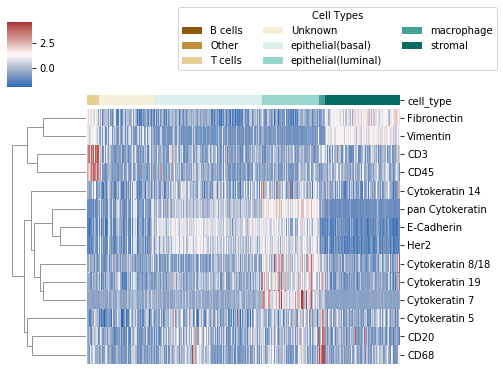

In [50]:
ast.type_clustermap(plot_name="./img/celltype_protein_cluster.png", threshold = 0.7, figsize=(7, 5))

Note: `threshold` is the probability threshold above which a cell is assigned to a cell type, default to 0.7. 

## 8. Hierarchical model specification <a class="anchor" id="8.-Hierarchical-model-specification"></a>

In the marker yaml file, the user can also add a section called `hierarchy`, which specifies the hierarchical structure of cell types. Here's an example:
```
hierarchy:
  immune:
    - B cells
    - T cells
    - macrophage
  epithelial:
    - epithelial(basal)
    - epithelial(luminal)
```

Some notes: 
1. The section would be accessed by key `hierarchy`.
2. In the section, the higher-levelled cell type names should be the keys.
3. The values in the section should also exist as the cell type names in the `cell_types` section. (e.g. if we have `"B cells"` in `marker["hierarchy"]["immune"]`, we should also be able to get `marker["cell_types"]["B cells"]`)

This section could be used to summarize the cell types assignment at a higher hierarchical level. (e.g. a cell is predicted as "immune" instead of "B cells" or "T cells")

In [53]:
hierarchy_probs = ast.assign_celltype_hierarchy()
hierarchy_probs.head()

,immune,epithelial
BaselTMA_SP43_115_X4Y8_1,0.435195,0.005911
BaselTMA_SP43_115_X4Y8_2,0.385014,0.044718
BaselTMA_SP43_115_X4Y8_3,0.188510,0.330741
BaselTMA_SP43_115_X4Y8_4,0.444039,0.011956
BaselTMA_SP43_115_X4Y8_5,0.468241,0.017085


To make it more clear, here's a heatmap for the cell assignment in a higher hierarchy:

<img src="img/hierarchical_celltype_cluster.png" style="width:550px;height:400px;">

The way it is calculated is simply summing up the probabilities of the cell type assignments under the same hierarchy.

## 9. Using astir as command line tool <a class="anchor" id="9.-Using-astir-as-command-line-tool"></a>

`astir` could also be used as a command line tool with `csv` input. Here are some example.

To fit cell types on the sample `csv` file and marker with a design matrix, setting `n_init` to 3 and `batch_size` to 128:

In [1]:
!astir type ../../../astir/tests/test-data/test_data.csv ../../../astir/tests/test-data/jackson-2020-markers.yml data/test_data_type_assignments.csv --design ../../../astir/tests/test-data/design.csv --n_init 3 --batch_size 128  

training restart (final): 100%|███| 50/50 [200.79epochs/s, current loss: -591.9]
/Users/jinelles.h/Documents/Camlab/astir-top-level/astir/astir/astir.py:192: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


To fit cell states on the sample csv file and marker, setting `learning rate` to `5e-4`, `dropout_rate` to `0.2` and `batch_norm` to `True`:

In [3]:
!astir state ../../../astir/tests/test-data/test_data.csv ../../../astir/tests/test-data/jackson-2020-markers.yml data/test_data_type_assignments.csv --design ../../../astir/tests/test-data/design.csv --learning_rate 5e-4 --dropout_rate 0.2 --batch_norm True

/Users/jinelles.h/Documents/Camlab/astir-top-level/astir/astir/models/cellstate.py:236: UserWarning: Delta loss batch size is greater than the number of epochs
  warnings.warn("Delta loss batch size is greater than the number of epochs")
training restart (final): 100%|████| 50/50 [250.62epochs/s, current loss: 408.6]
/Users/jinelles.h/Documents/Camlab/astir-top-level/astir/astir/astir.py:327: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


Moreover, astir could also be used as a converter which converts `rds` file with `SingleCellExperiment` to `csv` file. [see more details](./data_loading.ipynb#7.-Converting-rds-file-(with-data-as-SingleCellExperiment)-to-csv-file)

Run `astir -h`, `astir type -h`, `astir state -h` and `astir convert -h` in the command line for more details.